# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [2]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [3]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [4]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../../DataCollection/Data/Trending_News/2025-05-28_01-09-03.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-27,13:31,Merck Declares $0.81 Quarterly Dividend; 4.2% ...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/assorted/merck-...
1,2025-05-27,12:38,Qualcomm-backed study finds Apple’s in-house m...,Investing.com -- Qualcomm Incorporated (NASDAQ...,https://www.investing.com/news/stock-market-ne...
2,2025-05-27,10:33,US Consumer bounces back sharply in May By Inv...,Investing.com -- Consumer confidence rebounded...,https://www.investing.com/news/economy-news/us...
3,2025-05-27,09:41,"Lynx: Risk priced in, Nvidia could surprise to...",Investing.com -- Nvidia stock could break out ...,https://www.investing.com/news/stock-market-ne...
4,2025-05-27,09:15,SoundHound shares jump as Piper Sandler starts...,Investing.com -- Piper Sandler has initiated c...,https://www.investing.com/news/stock-market-ne...


In [7]:
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [9]:
print(df.head())

  publish_date publish_time  \
0   2025-05-27        13:31   
1   2025-05-27        12:38   
2   2025-05-27        10:33   
3   2025-05-27        09:41   
4   2025-05-27        09:15   

                                               title  \
0  Merck Declares $0.81 Quarterly Dividend; 4.2% ...   
1  Qualcomm-backed study finds Apple’s in-house m...   
2  US Consumer bounces back sharply in May By Inv...   
3  Lynx: Risk priced in, Nvidia could surprise to...   
4  SoundHound shares jump as Piper Sandler starts...   

                                           body_text  \
0  Risk Disclosure: Trading in financial instrume...   
1  Investing.com -- Qualcomm Incorporated (NASDAQ...   
2  Investing.com -- Consumer confidence rebounded...   
3  Investing.com -- Nvidia stock could break out ...   
4  Investing.com -- Piper Sandler has initiated c...   

                                                 url  
0  https://www.investing.com/news/assorted/merck-...  
1  https://www.investing.com/

In [10]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [01:46<00:00,  5.35s/it]


In [11]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [12]:
print(df["title"][2],'\n\n',predicted[2])

US Consumer bounces back sharply in May By Investing.com 

 **Sentiment:**
Positive

**Summary:**
US consumer confidence rebounded sharply in May, ending a five-month streak of declines and significantly exceeding forecasts. The improvement was broad-based across demographics and included increased optimism about jobs, income, business conditions, and purchasing plans.

**Reasoning for Sentiment:**
The article emphasizes a strong "bounce back" in confidence, a significant jump in the index, and improved consumer expectations and purchasing plans, all of which are positive indicators for economic health and consumer spending.

**Importance to Stock news:**
5

**Reasoning for Importance:**
Consumer confidence is a key economic indicator that reflects the health of consumer spending, a major driver of the US economy and corporate profits, making this sharp rebound highly relevant for the stock market outlook.


In [13]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [14]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
1,2025-05-27,Qualcomm-backed study finds Apple’s in-house m...,Positive,5,A Qualcomm-funded study found that Qualcomm's ...
2,2025-05-27,US Consumer bounces back sharply in May By Inv...,Positive,5,US consumer confidence rebounded sharply in Ma...
3,2025-05-27,"Lynx: Risk priced in, Nvidia could surprise to...",Positive,5,Lynx Equity has raised its price target for Nv...
4,2025-05-27,SoundHound shares jump as Piper Sandler starts...,Positive,5,Piper Sandler has initiated coverage on SoundH...
6,2025-05-27,JPM highlights top 6 European investment ideas...,Positive,5,JPMorgan has outlined its top six European inv...
7,2025-05-27,"Next 300 points likely up for the S&P 500, say...",Positive,5,JPMorgan analysts predict the S&P 500's next m...
8,2025-05-27,New surveys show declining interest in EVs and...,Negative,5,New surveys from UBS and Stifel indicate a sig...
9,2025-05-27,StanChart sees Solana price rising over 50% by...,Positive,5,Standard Chartered has initiated coverage on S...
10,2025-05-27,Temu owner PDD Holdings shares fall sharply on...,Negative,5,"PDD Holdings, owner of Temu, reported first-qu..."
11,2025-05-27,Citi sees up to 8% downside for Stoxx 600 on T...,Negative,5,Citi analysts warn that the Stoxx 600 index co...


In [15]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [16]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

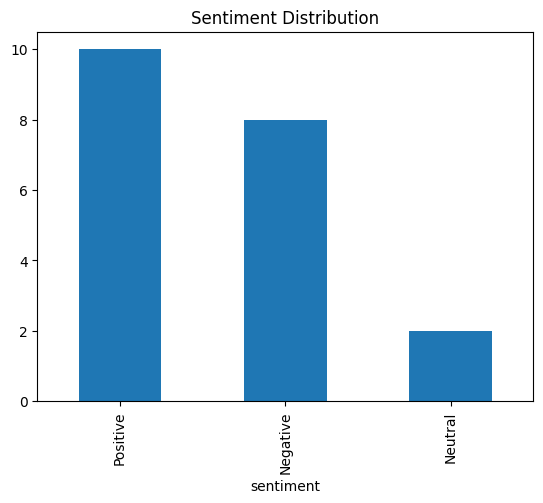

In [17]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

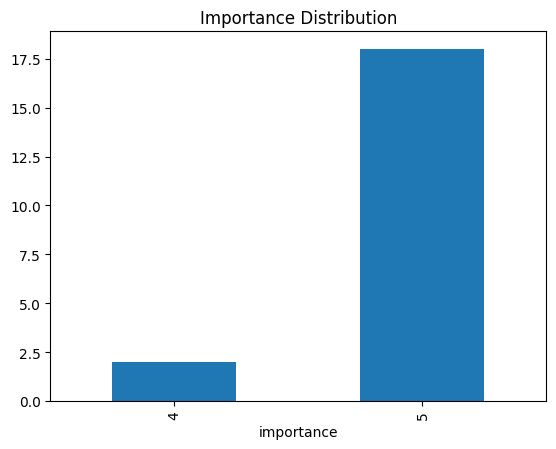

In [18]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [19]:
TICKER=current_stock

In [20]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [21]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [22]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: 0.1


In [23]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini/Gemini_{TICKER}_{date_time}.csv", index=False)